In [72]:
import pandas as pd
import cv2
import geopandas as gpd
import rasterio
import rasterio.mask
import geopandas as gpd
from shapely.geometry import mapping
import cv2
import numpy as np
import seaborn as sns

from rasterio.features import rasterize
import rasterio.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [77]:
class ColorDescriptor:
    def __init__(self, bins):
        # store the number of bins for the 3D histogram
        self.bins = bins

    def describe(self, image):
        # convert the image to the HSV color space and initialize
        # the features used to quantify the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        features = []
        
        bin_mask = np.all(image != 0, axis=-1).astype(np.uint8)
        # extract a color histogram from the elliptical region and
        # update the feature vector
        hist = self.histogram(image, bin_mask)
        features.extend(hist)

        # return the feature vector
        return features
    
    def histogram(self, image, mask):
        # extract a 3D color histogram from the masked region of the
        # image, using the supplied number of bins per channel
        hist = cv2.calcHist([image], [0, 1, 2], mask, self.bins,
            [0, 180, 0, 256, 0, 256])

        hist = cv2.normalize(hist, hist).flatten()

        # return the histogram
        return hist

In [78]:
raster_path = "/home/user/projects/africa_starving/data/images/S2A_MSIL1C_20170101T082332_N0204_R121_T34JEP_20170101T084543.SAFE/GRANULE/L1C_T34JEP_A007983_20170101T084543/IMG_DATA/T34JEP_20170101T082332_TCI.jp2"
train_df = gpd.read_file("/home/user/projects/africa_starving/data/train/train/train_repr.geojson")

In [88]:
train_df['Crop_Id_Ne']

0       8
1       6
2       8
3       8
4       8
5       8
6       8
7       8
8       8
9       8
10      7
11      9
12      9
13      1
14      8
15      8
16      8
17      8
18      8
19      5
20      3
21      4
22      3
23      9
24      8
25      8
26      8
27      8
28      8
29      5
       ..
2464    6
2465    6
2466    6
2467    6
2468    6
2469    6
2470    6
2471    6
2472    6
2473    6
2474    6
2475    6
2476    6
2477    6
2478    6
2479    6
2480    6
2481    6
2482    6
2483    6
2484    6
2485    6
2486    6
2487    6
2488    6
2489    6
2490    6
2491    6
2492    6
2493    6
Name: Crop_Id_Ne, Length: 2494, dtype: object

In [148]:
src = rasterio.open(raster_path, 'r')
imgs = []
labels = []
for num, row in train_df.iterrows():
    try:
        masked_image, out_transform = rasterio.mask.mask(src, [mapping(row['geometry'])], crop=True, nodata=0)
        img_to_test = rasterio.plot.reshape_as_image(masked_image)
        imgs.append(img_to_test)
        labels.append(row["Crop_Id_Ne"])
        #masked_image = normalize(masked_image, x_min=norm_dict.get("B08").get('min'), x_max=norm_dict.get("B08").get('max'))
    except Exception as e:
        #print(e)
        continue
#     if num > 100:
#         break

In [187]:
len(imgs)

2344

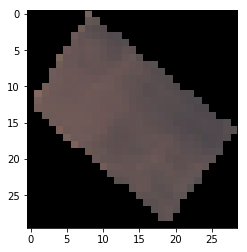

In [150]:
plt.imshow(img_to_test)

In [182]:
cd = ColorDescriptor((8, 12, 6))

In [183]:
hists = []
for img in imgs:
    hists.append(cd.describe(img))

/home/user/.virtualenvs/cv34/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


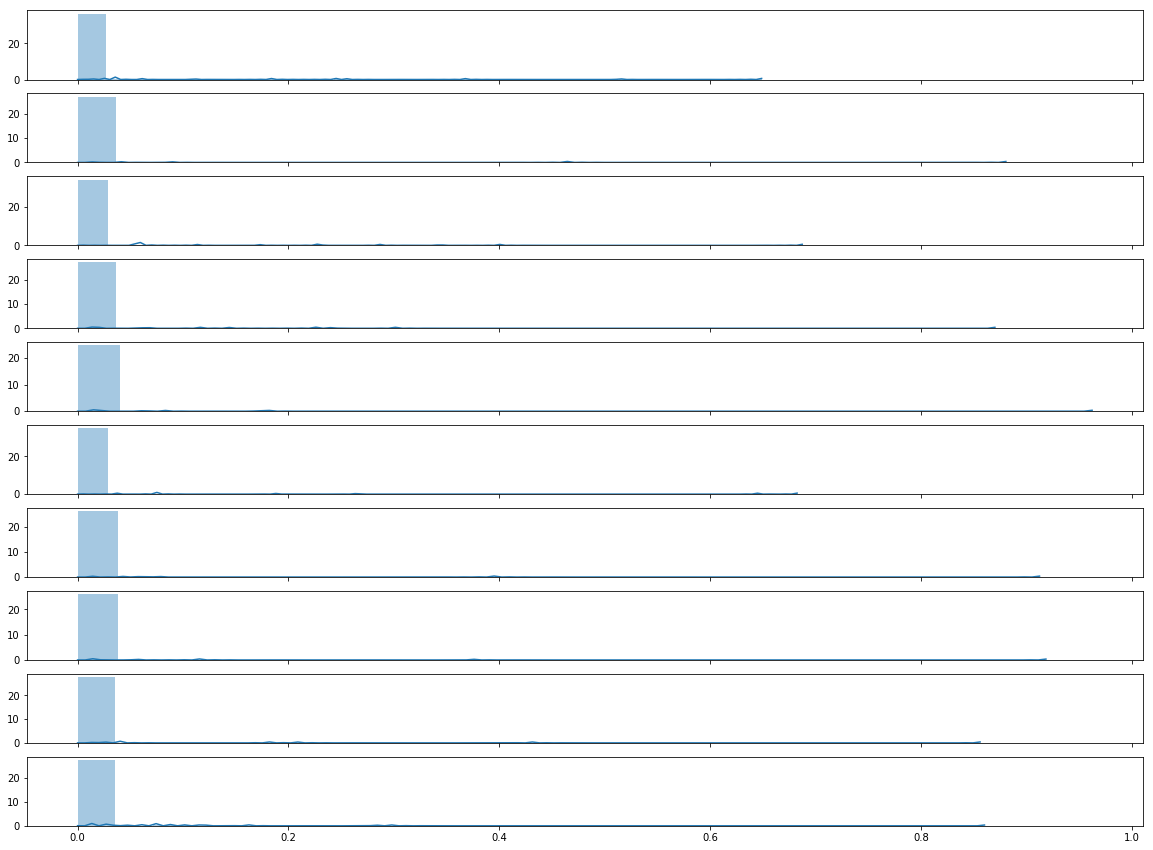

In [184]:
# plot

f, axes = plt.subplots(len(hists[:10]), 1, figsize=(20, 15), sharex=True)
for num, i in enumerate(hists[:10]):
    sns.distplot(i, ax=axes[num])


In [98]:
def chi2_distance(histA, histB, eps = 1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
        for (a, b) in zip(histA, histB)])

    # return the chi-squared distance
    return d

In [158]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [146]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    lbls = unique_labels(y_true, y_pred)
    lbls = [int(lbl) - 1 for lbl in lbls]
    classes = classes[lbls]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [185]:
len(hists[0])

576

In [186]:
neigh = KNeighborsClassifier(n_neighbors=3, metric=chi2_distance)

cross_val_score(neigh, hists[:500], labels[:500], cv=5, n_jobs=-1, verbose=3)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV] ...................... , score=0.45454545454545453, total=  55.6s
[CV]  ................................................................
[CV] ...................... , score=0.36538461538461536, total=  59.9s
[CV] ...................... , score=0.43137254901960786, total=  59.0s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.0min remaining:  1.5min


[CV] ...................... , score=0.45918367346938777, total=  56.4s
[CV] ....................... , score=0.4742268041237113, total=  31.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


array([0.36538462, 0.43137255, 0.45454545, 0.45918367, 0.4742268 ])

In [167]:
from sklearn.model_selection import train_test_split

In [168]:
X_train, X_test, y_train, y_test = train_test_split(
    hists, labels, test_size=0.2, random_state=42)

In [169]:
neigh = KNeighborsClassifier(n_neighbors=3, metric=chi2_distance)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function chi2_distance at 0x7fed5717dd08>,
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [171]:
y_pred = neigh.predict(X_test[:100])

In [172]:
y_test = y_test[:100]

In [173]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.38

In [131]:
class_names = pd.read_csv("/home/user/projects/africa_starving/data/crop_id_list.csv")

In [144]:
class_names['crop'].values

array(['Cotton', 'Dates', 'Grass', 'Lucern', 'Maize', 'Pecan', 'Vacant',
       'Vineyard', 'Vineyard & Pecan ("Intercrop")'], dtype=object)

Confusion matrix, without normalization
[[ 2  0  1  2  0  0  0  0]
 [ 0  1  2  1  0  1  0  0]
 [ 0  1  8  0  1  0  8  0]
 [ 1  0  4  6  2  1  0  0]
 [ 0  0  1  0  0  1  0  0]
 [ 2  2  1  2  0  4  3  0]
 [ 4  1 15  0  0  1 17  1]
 [ 0  0  0  0  0  0  3  0]]
Normalized confusion matrix
[[0.4        0.         0.2        0.4        0.         0.
  0.         0.        ]
 [0.         0.2        0.4        0.2        0.         0.2
  0.         0.        ]
 [0.         0.05555556 0.44444444 0.         0.05555556 0.
  0.44444444 0.        ]
 [0.07142857 0.         0.28571429 0.42857143 0.14285714 0.07142857
  0.         0.        ]
 [0.         0.         0.5        0.         0.         0.5
  0.         0.        ]
 [0.14285714 0.14285714 0.07142857 0.14285714 0.         0.28571429
  0.21428571 0.        ]
 [0.1025641  0.02564103 0.38461538 0.         0.         0.02564103
  0.43589744 0.02564103]
 [0.         0.         0.         0.         0.         0.
  1.         0.        ]]


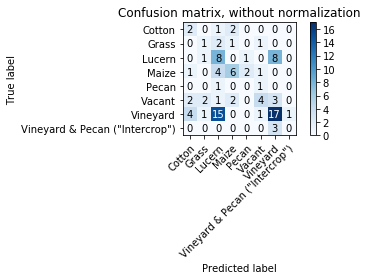

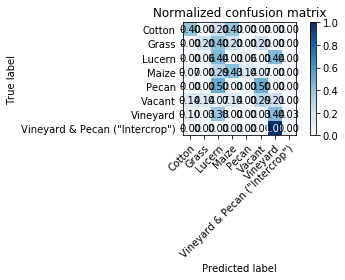

In [174]:
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names['crop'].values,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names['crop'].values, normalize=True,
                      title='Normalized confusion matrix')

In [105]:
hists[0].shape

AttributeError: 'list' object has no attribute 'shape'